In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F

In [3]:
# Configurations for exploring
batch_size = 1              # sample batch size
tokens = 5                  # sample token size

# Actual architecture configs
embedding_size = 64         # embedding size for tokens and position embeddings
block_size = 10             # limiting input sequence to length to max 
vocab_size = 100            # total number of vocab known to our model
n_head = 4                  # number of attention heads

# 1.1 GPT
- token embedding
- postion embedding
- heads
- layer norm
- mlp head

In [4]:
## a single batch of text, the text contains 5
idx = torch.randint(0, vocab_size, (batch_size, tokens))  # (B, T)
idx

tensor([[47, 92, 51, 16, 43]])

In [5]:
# Convert to Token Embedding
wte = nn.Embedding(vocab_size, embedding_size)
tok_emb = wte(idx)  # (B, T, C) where C is embedding_size
print("Token embedding (tok_emb) shape:", tok_emb.shape)

Token embedding (tok_emb) shape: torch.Size([1, 5, 64])


In [6]:
# Position Embedding
wpe = nn.Embedding(block_size, embedding_size)
pos = torch.arange(0, tokens, dtype=torch.long)  # (T)
pos_emb = wpe(pos)  # (T, C)
print("Position embedding (pos_emb) shape:", pos_emb.shape)
x = tok_emb + pos_emb  # (B, T, C)
print("Combined embedding (x) shape:", x.shape)

Position embedding (pos_emb) shape: torch.Size([5, 64])
Combined embedding (x) shape: torch.Size([1, 5, 64])


### at this stage you should know

0. nn.Embedding is like lookup table, mapping indices to vectors - and we have 2 of them - 

1. `wte` is the token embedding - take the incoming token return its corresponding embedding (will be of shape `embedding_size`). So the size of this is `embedding_size` for each token or in other words our total vocabulary size (`vocab_size`).

2. `wpe` is the position embedding - take the position of the token and returns an embedding. we have decided to only have max sequence length of `block_size`, therefore all we need is `embedding_size` for each of the `block_size`

In [7]:
## We are altogether skipping the TRANSFORMER BLOCK HERE 
## which will take as input shape (B, T, C) and also returns (B, T, C)

## and finally -- 
lm_head = nn.Linear(embedding_size, vocab_size, bias=False)
logits = lm_head(x)  # (B, T, vocab_size)
print("Logits shape:", logits.shape)

Logits shape: torch.Size([1, 5, 100])


## 1.2 Block
- Layer Norm
- CausalSelfAttention   <\Will go in next sections>
- Layer Norm
- MLP                   <\Will go in next sections>

--- 

- residual all the way
- t1 <-- attention of (layer norm of input) + input
- t2 <-- mlp on (layer norm of t1) + t1 

## 1.3 CausalSelfAttention


In [8]:
x = torch.randn(batch_size, tokens, embedding_size)
print("Input shape:", x.shape)


Input shape: torch.Size([1, 5, 64])


In [9]:
# Query, Key, Value projections
c_attn = nn.Linear(embedding_size, 3 * embedding_size)  # combines Q,K,V in one linear layer
qkv = c_attn(x)  # (B, T, 3*embedding_size)
print("QKV combined shape:", qkv.shape)  # (1, 5, 192)

QKV combined shape: torch.Size([1, 5, 192])


In [10]:
# Split into Q, K, V
q, k, v = qkv.split(embedding_size, dim=2)  # each has shape (B, T, embedding_size), just pytorch stuff
print("Query shape:", q.shape)  # (1, 5, 64)
print("Key shape:", k.shape)    # (1, 5, 64)
print("Value shape:", v.shape)  # (1, 5, 64)

Query shape: torch.Size([1, 5, 64])
Key shape: torch.Size([1, 5, 64])
Value shape: torch.Size([1, 5, 64])


In [11]:
# Reshape Q,K,V for multi-head attention
head_size = embedding_size // n_head  # 64 // 4 = 16
q = q.view(batch_size, tokens, n_head, head_size).transpose(1, 2)  # (B, nh, T, hs)
k = k.view(batch_size, tokens, n_head, head_size).transpose(1, 2)
v = v.view(batch_size, tokens, n_head, head_size).transpose(1, 2)
print("Query shape after reshape:", q.shape)  # (1, 4, 5, 16)


Query shape after reshape: torch.Size([1, 4, 5, 16])


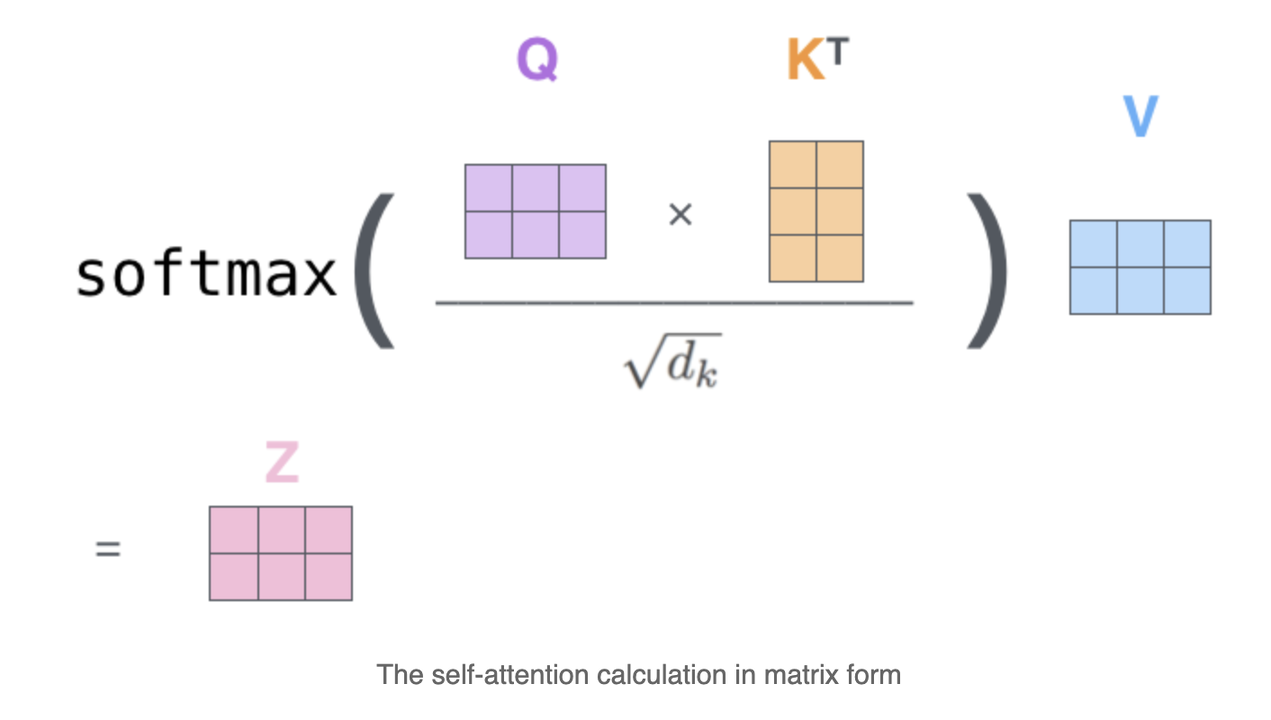

In [12]:
# Compute attention scores
att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(head_size))
print("Attention scores shape:", att.shape)  # (1, 4, 5, 5)

Attention scores shape: torch.Size([1, 4, 5, 5])


In [13]:
# Create causal mask (lower triangular)
mask = torch.tril(torch.ones(tokens, tokens))
print("\nCausal mask:")
print(mask)


Causal mask:
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])


In [14]:
# Apply mask and softmax
att = att.masked_fill(mask==0, float('-inf'))
att = F.softmax(att, dim=-1)
print("\nMasked attention scores (first head):")
print(att[0,0])  # Show first head's attention pattern



Masked attention scores (first head):
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5058, 0.4942, 0.0000, 0.0000, 0.0000],
        [0.2363, 0.3002, 0.4635, 0.0000, 0.0000],
        [0.3001, 0.2779, 0.2532, 0.1688, 0.0000],
        [0.1949, 0.2504, 0.0875, 0.2857, 0.1815]], grad_fn=<SelectBackward0>)


In [15]:
# Apply attention to values
y = att @ v  # (B, nh, T, hs)
print("\nOutput after attention shape:", y.shape)  # (1, 4, 5, 16)



Output after attention shape: torch.Size([1, 4, 5, 16])


In [16]:
# Reshape back
y = y.transpose(1, 2).contiguous().view(batch_size, tokens, embedding_size)
print("Final output shape:", y.shape)  # (1, 5, 64)

Final output shape: torch.Size([1, 5, 64])


In [17]:
# Projection
c_proj = nn.Linear(embedding_size, embedding_size)
y = c_proj(y)
print(f"After final Projection - {y.shape}")

After final Projection - torch.Size([1, 5, 64])
